In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

# Load Data
We load MNIST data from the torchvision datasets.

In [2]:
# Load the training dataset
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True)
# Convert tensors to numpy arrays
train_dataset.data = train_dataset.data.detach().cpu().numpy()
train_dataset.targets = train_dataset.targets.detach().cpu().numpy()

# Load the test dataset
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              download=True)
# Convert tensors to numpy arrays
test_dataset.data = test_dataset.data.detach().cpu().numpy()
test_dataset.targets = test_dataset.targets.detach().cpu().numpy()

### Example Images

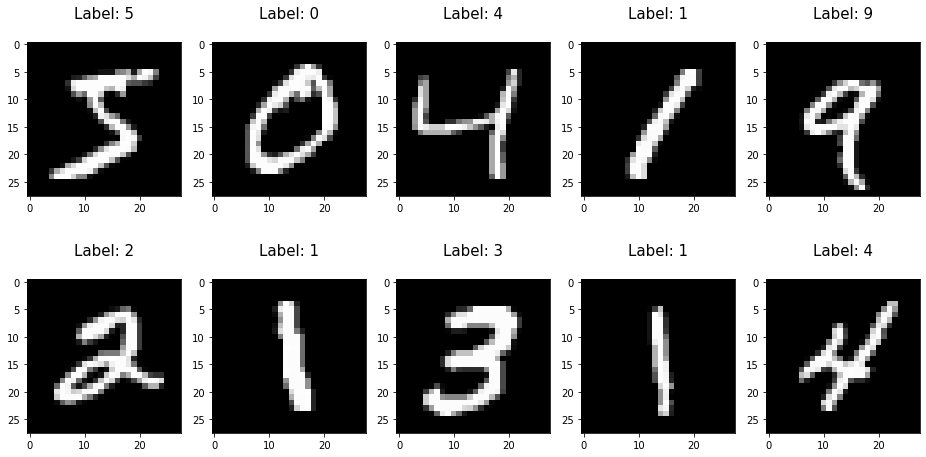

In [3]:
# Display example images from the dataset
plt.figure(figsize=(16,8))
for index in range(10):
    plt.subplot(2, 5, index + 1)
    image = train_dataset.data[index]
    label = train_dataset.targets[index]
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 15);

# Data Processing

We perform the following data processing steps
#### Label Conversion
#### Z Score Normalization
#### Adding bias feature
#### Train - Val Split

More details follow below

### Label Conversion

To align our data with the logistic regression task, we need to transform our labels. In our dataset, labels 0 and 3 are initially assigned to distinct classes. However, for logistic regression, it's common to work with binary classification problems. Therefore, we'll map label 0 to class 0 and label 3 to class 1. This conversion ensures that our model predicts the probability of belonging to class 1 (label 3) and the complementary class (label 0). <br>
You can choose to work with different pairs and compare the results

In [4]:
# Define labels for class 0 and class 3
label1 = 0 #Will be the false value
label2 = 3 #Will be the true value

### Preprocessing functions
We define some function that would help us with data normalization, train-test split and reshaping the data for using with logistic model

## z_score_normalize

Performs z-score normalization on a given dataset.

Formula: $ f(x) = \frac{x - μ}{σ} $

- `X`: The data to z-score normalize.
- `u` (optional): The mean to use when normalizing. If not provided, computed from the data.
- `sd` (optional): The standard deviation to use when normalizing. If not provided, computed from the data.

Returns a tuple containing:
- Transformed dataset with mean 0 and standard deviation 1.
- Computed statistics (mean and standard deviation) for the dataset to undo z-scoring.


In [5]:
def z_score_normalize(X, u=None, sd=None):
    """
    Performs z-score normalization on X.

    f(x) = (x - μ) / σ
        where
            μ = mean of x
            σ = standard deviation of x

    Parameters
    ----------
    X : np.array
        The data to z-score normalize
    u (optional) : np.array
        The mean to use when normalizing
    sd (optional) : np.array
        The standard deviation to use when normalizing

    Returns
    -------
        Tuple:
            Transformed dataset with mean 0 and stdev 1
            Computed statistics (mean and stdev) for the dataset to undo z-scoring.
    """
    # If mean and standard deviation are not provided, compute them
    if u is None:
        u = np.mean(X)
    if sd is None:
        sd = np.std(X)
    
    # Handle the case of zero standard deviation
    if sd == 0:
        return X, (0, 0)
    
    # Perform z-score normalization    
    transformed_X = (X - u) / sd
    
    return transformed_X, (u, sd)

## append_bias

Appends a bias term to a dataset.

- `X`: 2D numpy array with shape (N, d), where N is the number of samples and d is the number of features.

Returns a 2D numpy array with shape ((N+1), d) after adding a bias column.

In [6]:
def append_bias(X):
    """
    Append bias term for dataset.

    Parameters
    ----------
    X : np.array
        2d numpy array with shape (N,d)

    Returns
    -------
        np.array:
        2d numpy array with shape ((N+1),d)
    """
    
    bias_array = np.ones((X.shape[0],1))
    return np.concatenate((bias_array,X),axis=1)

### Train Val Split
In the following code, we create our train set and val set for training and validation, respectively, by breaking the train dataset into two parts. This separation allows us to train our model on one portion of the data and evaluate its performance on another, helping us to assess generalization.

We also use the normalization function we defined above to z-normalize the images and reshape them to flatten the pixels into one dimension. Z-normalization ensures that the pixel values have a mean of 0 and a standard deviation of 1, which is important when using sigmoid-like activation functions to avoid overflow and exploding/vanishing gradients.

Finally, we add a bias term to the input features. This is done to have an intercept term in our model, which allows the model to capture the baseline value or starting point of the prediction. 

In [7]:
# Extract and preprocess training data for binary classification
# Select data samples with labels matching either label1 or label2
matching_indices = np.where(np.logical_or(train_dataset.targets == label1, train_dataset.targets == label2))

Xtrain = train_dataset.data[matching_indices]
ytrain = train_dataset.targets[matching_indices]

# Convert labels to binary values (0 for label1 and 1 for label2)
ytrain = np.select([ytrain == label1, ytrain == label2], [0, 1], ytrain)

print("Xtrain shape before reshaping:", Xtrain.shape)
print("ytrain shape before reshaping:", ytrain.shape)

# Reshape ytrain to match the shape requirements of the model
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

print("Xtrain shape after reshaping:", Xtrain.shape)
print("ytrain shape after reshaping:", ytrain.shape)

# Apply z-score normalization to the training data
normalized_Xtrain, (mean, std) = z_score_normalize(Xtrain)

# Create a tuple containing the preprocessed data and labels
dataset = (normalized_Xtrain, ytrain)

# Split the dataset into training and validation sets
num_validation_samples = 2060
train_set = (dataset[0][:-num_validation_samples], dataset[1][:-num_validation_samples])
val_set = (dataset[0][-num_validation_samples:], dataset[1][-num_validation_samples:])

print("train_set shapes after splitting:")
print("Features:", train_set[0].shape)
print("Labels:", train_set[1].shape)

print("val_set shapes after splitting:")
print("Features:", val_set[0].shape)
print("Labels:", val_set[1].shape)

train_set = append_bias(train_set[0]), train_set[1]
val_set = append_bias(val_set[0]), val_set[1]

print("train_set shapes after adding bias term:")
print("Features:", train_set[0].shape)
print("Labels:", train_set[1].shape)

print("val_set shapes after adding bias term:")
print("Features:", val_set[0].shape)
print("Labels:", val_set[1].shape)

Xtrain shape before reshaping: (12054, 28, 28)
ytrain shape before reshaping: (12054,)
Xtrain shape after reshaping: (12054, 784)
ytrain shape after reshaping: (12054, 1)
train_set shapes after splitting:
Features: (9994, 784)
Labels: (9994, 1)
val_set shapes after splitting:
Features: (2060, 784)
Labels: (2060, 1)
train_set shapes after adding bias term:
Features: (9994, 785)
Labels: (9994, 1)
val_set shapes after adding bias term:
Features: (2060, 785)
Labels: (2060, 1)


### Do the same steps for test dataset, except splitting

In [8]:
test_indices = np.where(np.logical_or(test_dataset.targets == label1, test_dataset.targets == label2))
Xtest = test_dataset.data[test_indices]
ytest = test_dataset.targets[test_indices]
    
ytest = np.select([ytest == label1, ytest == label2], [0,1], ytest)
Xtest = Xtest.reshape(Xtest.shape[0], -1)
ytest = ytest.reshape(ytest.shape[0],1)
    
normalized_Xtest, (mean, std) = z_score_normalize(Xtest)

test_set = (normalized_Xtest, ytest)

test_set = append_bias(test_set[0]), test_set[1]
print("test_set shapes after adding bias term:")
print("Features:", val_set[0].shape)
print("Labels:", val_set[1].shape)

test_set shapes after adding bias term:
Features: (2060, 785)
Labels: (2060, 1)


# Logistic Regression Model

We define the skeleton for our model below and some functions to be used in the calculation

### Activation and Training Functions
We define some function that will help us with training our model and will also be used for loss and activation 

## generate_minibatches

Generates minibatches from a given dataset.

- `dataset`: A tuple containing input patterns and their corresponding targets.
- `batch_size` (optional): The size of each minibatch. Default is 64.

Yields minibatches, each containing input patterns and their corresponding targets.

In [9]:
def generate_minibatches(dataset, batch_size=64):
    """
    Generate minibatches from a given dataset.

    This function takes a dataset and divides it into minibatches of the specified size.

    Parameters
    ----------
    dataset : tuple
        The dataset containing input patterns and their corresponding targets
    batch_size : int, optional
        The size of each minibatch, default is 64

    Yields
    ------
    tuple
        A minibatch containing input patterns and their corresponding targets
    """
    X, y = dataset
    left_idx, right_idx = 0, batch_size
    
    # Generate minibatches until the entire dataset is covered
    while right_idx < len(X):
        yield X[left_idx:right_idx], y[left_idx:right_idx]
        left_idx, right_idx = right_idx, right_idx + batch_size
    
    # Yield the remaining data as the last minibatch
    yield X[left_idx:], y[left_idx:]

## binary_cross_entropy

Computes binary cross-entropy loss.

Formula: $ L(x) = t \cdot \ln(y) + (1 - t) \cdot \ln(1 - y) $

- `y`: The network's predictions.
- `t`: The corresponding targets.

Returns the binary cross-entropy loss value.

In [10]:
def binary_cross_entropy(y, t):
    """
    Compute binary cross entropy.

    L(x) = t*ln(y) + (1-t)*ln(1-y)

    Parameters
    ----------
    y : np.array
        The network's predictions
    t : np.array
        The corresponding targets
    Returns
    -------
    float 
        binary cross entropy loss value according to above definition
    """

    # Initialize an array to store the computed binary cross entropy values
    ret = np.zeros_like(y)
    
    # Find indices where target t is equal to 0
    t_indices = np.where(t == 0)
    
    # Compute the binary cross entropy values for cases where t = 0
    # TODO (1-t)*ln(1-y)
    ret[t_indices] += np.multiply((1 - t)[t_indices], np.log(1 - y)[t_indices])
    
    # Find indices where target t is not equal to 0
    nont_indices = np.where(t != 0)
    
    # Compute the binary cross entropy values for cases where t != 0
    # TODO t*ln(y)
    ret[nont_indices] += ??TODO??
    
    # Calculate the negative average of the computed binary cross entropy values
    return -np.average(ret)

## sigmoid

Computes the sigmoid function.

Formula: $ f(x) = \frac{1}{1 + e^{-x}} $

- `x`: The internal value while a pattern goes through the network.

Returns the value after applying the sigmoid function.

In [11]:
def sigmoid(x):
    """
    Compute the sigmoid function.

    f(x) = 1 / (1 + e ^ (-x))

    Parameters
    ----------
    a
        The internal value while a pattern goes through the network
    Returns
    -------
    float
       Value after applying sigmoid (z from the slides).
    """
    # Clip the input value to a range of [-20, 20] to prevent numerical instability
    # This ensures that the exponential values won't become too large or too small
    x = np.clip(x, -20, 20)
    
    # Apply the sigmoid function in a numerically stable way
    # If x is greater than or equal to 0, compute: 1 / (1 + e ^ (-x))
    # If x is less than 0, compute: e ^ x / (1 + e ^ x)
    # TODO: compute it using numpy
    # hint: 1 / (1 + e ^ (-x))
    stm_x_ge_0 = ????
    # hint: e ^ x / (1 + e ^ x)
    stm_x_nge_0 = ????
    res = np.where(x >= 0, 
                    stm_x_ge_0, 
                    stm_x_nge_0)
    return res


### Model Class
We will define a class called `LogisticNetwork` that represents a logistic regression neural network. This class will have methods for initialization, forward propagation, training, and testing. The network will be trained using mini-batches and updated using gradient descent. The goal of this class is to create a basic 

The `LogisticNetwork` class will have the following methods:

- `__init__(self, lr, in_dim)`: Initialize the network with the given learning rate (`lr`) and input dimension (`in_dim`). It will set up the weight matrix and save hyperparameters.

- `forward(self, X)`: Perform forward propagation to compute the network's output for the given input patterns (`X`). The activation function used will be the sigmoid function.

- `train(self, minibatch)`: Train the network on a given minibatch of data. Update the network's weights using gradient descent based on the computed loss.

- `test(self, minibatch)`: Test the network on a given minibatch of data to evaluate its performance without updating the weights.

Let's now define the `LogisticNetwork` class and its methods.


In [12]:
class LogisticNetwork:
    def __init__(self, lr, in_dim):
        """
        Perform required setup for the network.

        Initialize the weight matrix, save hyperparameters.

        Parameters
        ----------
        """
        self.lr = lr
        self.weights = np.zeros((in_dim+1, 1))
#         print(self.weights.shape)

    def forward(self, X):
        """
        Apply the model to the given patterns

        Use `self.weights` and `sigmoid` to compute the network's output

        f(x) = σ(w*x)
            where
                σ = non-linear activation function
                w = weight matrix

        Parameters
        ----------
        X
            Patterns to create outputs for
        """
        A = np.matmul(X, self.weights)
        return sigmoid(A)

    def __call__(self, X):
        return self.forward(X)

    def train(self, minibatch):
        """
        Train the network on the given minibatch

        Use `self.weights` and `sigmoid` to compute the network's output
        Use `binary_cross_entropy` and its gradient to update the network.

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
        tuple containing:
            average loss over minibatch
            accuracy over minibatch
        """
        X, y = minibatch
        y_pred = self.forward(X)
        
        #update rule
        self.weights = self.weights + self.lr*np.matmul(X.T,(y-y_pred))
        
        avg_loss = binary_cross_entropy(y_pred, y) 

        decoded_y = np.copy(y)
        
        if(self.weights.shape[1]==1):
            ypred_label = np.copy(y_pred)
            ypred_label[ypred_label >= 0.5] = 1
            ypred_label[ypred_label < 0.5] = 0
        else:
            ypred_label = onehot_decode(y_pred)
            decoded_y = onehot_decode(y)

        correct = np.count_nonzero((decoded_y-ypred_label)==0)
        accuracy = correct/decoded_y.shape[0]
        
        return (avg_loss, accuracy)
            

    def test(self, minibatch):
        """
        Test the network on the given minibatch

        Use `self.weights` and `sigmoid` to compute the network's output
        Use `binary_cross_entropy` to compute the loss.
        We do NOT update the weights in this method!

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
            tuple containing:
                average loss over minibatch
                accuracy over minibatch
        """
        X, y = minibatch
        y_pred = self.forward(X)

        avg_loss = binary_cross_entropy(y_pred, y)
        
        decoded_y = np.copy(y)
        
        if(self.weights.shape[1]==1):
            ypred_label = np.copy(y_pred)
            ypred_label[ypred_label >= 0.5] = 1
            ypred_label[ypred_label < 0.5] = 0
        else:
            ypred_label = onehot_decode(y_pred)
            decoded_y = onehot_decode(y)
        
        correct = np.count_nonzero((decoded_y-ypred_label)==0)
        accuracy = correct/decoded_y.shape[0]
        
        return (avg_loss, accuracy)


# Training and Evaluation

### Logistic Regression Training with Early Stopping

We train our logistic regression model using mini-batch gradient descent and keep track of various metrics during training, including the training loss, validation loss, and validation accuracy. These metrics provide insights into how well the model is learning and generalizing to unseen data. <br>
To prevent overfitting and improve training efficiency, the code implements early stopping. If the validation loss starts increasing after a certain number of epochs, the training process is halted early. 

In [13]:
# Define the number of training epochs
epochs = 1000

# Initialize arrays to store training and validation losses, and validation accuracies
train_losses = np.full((epochs,), np.nan)
val_losses = np.full((epochs,), np.nan)
val_accuracies = np.full((epochs,), np.nan)

# Create an instance of the LogisticNetwork class with a learning rate and input size
logisticRegressionModel = LogisticNetwork(0.0001, 28*28)

# Loop through the specified number of epochs
for iter in range(epochs):
    # Initialize variables to calculate average training loss per batch
    train_loss_batch_avg = 0
    batches = 0
    
    # Iterate over mini-batches from the training dataset
    for minibatch in generate_minibatches(train_set, 50):
        # Train the logistic regression model on the current mini-batch
        train_loss, train_accuracy = logisticRegressionModel.train(minibatch)
        
        # Accumulate the training loss and update the batch count
        train_loss_batch_avg += train_loss
        batches += 1
    
    # Test the trained model on the validation dataset
    val_loss, val_accuracy = logisticRegressionModel.test(val_set)
    
    # Store the calculated training and validation metrics for the current iteration
    train_losses[iter] = train_loss_batch_avg / batches
    val_losses[iter] = val_loss
    val_accuracies[iter] = val_accuracy
    
    # Print the metrics for every 50th iteration
    if iter % 50 == 0:
        print('Epoch: {}. Train Loss: {:.4f}. Val Loss: {:.4f}. Val Accu: {:.4f} %'.format(iter, train_losses[iter], val_losses[iter], val_accuracies[iter]))

    # Implement early stopping if validation loss starts to increase
    if iter >= 2 and val_losses[iter - 1] >= val_losses[iter - 2]:
        print("EARLY STOPPED")
        break

Epoch: 0. Train Loss: 0.1258. Val Loss: 0.0632. Val Accu: 0.9864 %
Epoch: 50. Train Loss: 0.0173. Val Loss: 0.0160. Val Accu: 0.9937 %
Epoch: 100. Train Loss: 0.0145. Val Loss: 0.0141. Val Accu: 0.9932 %
Epoch: 150. Train Loss: 0.0130. Val Loss: 0.0132. Val Accu: 0.9932 %
Epoch: 200. Train Loss: 0.0118. Val Loss: 0.0127. Val Accu: 0.9942 %
Epoch: 250. Train Loss: 0.0110. Val Loss: 0.0122. Val Accu: 0.9942 %
Epoch: 300. Train Loss: 0.0102. Val Loss: 0.0119. Val Accu: 0.9947 %
Epoch: 350. Train Loss: 0.0096. Val Loss: 0.0117. Val Accu: 0.9947 %
Epoch: 400. Train Loss: 0.0091. Val Loss: 0.0115. Val Accu: 0.9947 %
Epoch: 450. Train Loss: 0.0086. Val Loss: 0.0113. Val Accu: 0.9951 %
Epoch: 500. Train Loss: 0.0082. Val Loss: 0.0111. Val Accu: 0.9951 %
Epoch: 550. Train Loss: 0.0078. Val Loss: 0.0110. Val Accu: 0.9951 %
Epoch: 600. Train Loss: 0.0075. Val Loss: 0.0109. Val Accu: 0.9956 %
Epoch: 650. Train Loss: 0.0072. Val Loss: 0.0108. Val Accu: 0.9956 %
Epoch: 700. Train Loss: 0.0069. Val L

# Training and Validation Plots

The following plot provides valuable insights into the training process and helps identify any anomalies:

This visualization allows us to:
- Monitor the **training and validation loss** to gauge the model's convergence and potential overfitting.
- Track the **validation accuracy** to assess how well the model generalizes.

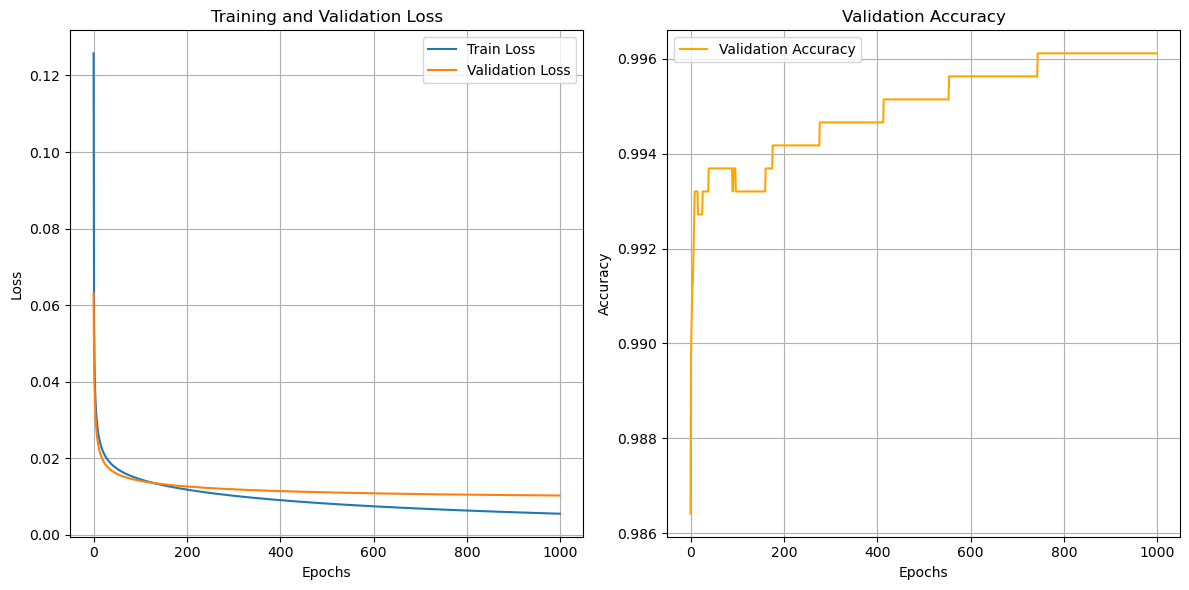

In [14]:
plt.figure(figsize=(12, 6))

# Plotting Training Loss and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Weights Visualization

The code below visualizes the weights of the the logistic regression model. The initial set of weights corresponds to the bias, which is often not of primary interest. Therefore, we focus on visualizing the weights associated with the actual features.

By reshaping and plotting the weights as an image, we gain insights into how the model learns and assigns importance to different features. This can help us interpret the learned patterns and identify which areas of the input data contribute most to the model's decisions.

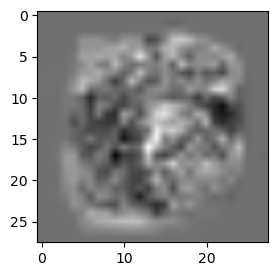

In [15]:
# The first set of weights is the bias, we can ignore those
layer_weights = logisticRegressionModel.weights[1:]
layer_biases = logisticRegressionModel.weights[0]

plt.figure(figsize=(3,3))
plt.imshow(layer_weights.reshape(28,28), cmap = 'gray', interpolation = 'bilinear')

Let's look at how this compares to the simply taking the difference of average image for label2 and label1 in the train dataset 

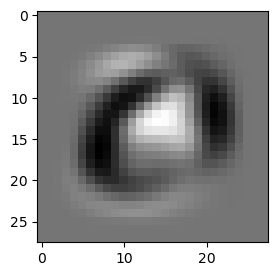

In [16]:
label1data = []
label2data = []
for data, label in zip(train_set[0], train_set[1]):
    if label == 0: 
        label1data.append(data[1:])
    elif label == 1:
        label2data.append(data[1:])
        
label1data = np.array(label1data)        
label2data = np.array(label2data)


avg_label2 = np.sum(label2data, axis = 0)/label2data.shape[0]
avg_label1 = np.sum(label1data, axis = 0)/label1data.shape[0]

diff_img = avg_label2 - avg_label1

plt.figure(figsize=(3,3))
plt.imshow(diff_img.reshape(28,28), cmap = 'gray')

### Test Performance
Now that we have trained our model , we can use our test set to test its performance



In [17]:
test_loss, test_accuracy = logisticRegressionModel.test(test_set)
print("TEST ACCURACY:", test_accuracy)

TEST ACCURACY: 0.9964824120603015


# Softmax Regression Model

Logistic Regression is limited to the task of binary classification. We can replace the sigmoid activation with a softmax activation which should give us 'n' probability values in the output instead of just one, where 'n' is the number of classes in a multiclass classification problem. We can then choose the class with the highest probability as the predicted class. We would also need to calculate an appropriate loss on these values.

# Data Processing

We would need to perform the following data processing steps
#### Z Score Normalization
#### Adding bias feature
#### Onehot encoding
#### Train - Val Split

Note that all other steps stay the same, but we don't need to convert the labels for classification. Instead, we would need a one hot encoded version of labels, which means that for each dat apoint we have 'n' 0-1 values, 'n' being the number of classes, it would have 1 corresponding to only one class.

Below we define functions to one hot encode and decode to help with processing and evaluation

In [18]:
def onehot_encode(y):
    """
    Performs one-hot encoding on y.

    Ideas:
        NumPy's `eye` function

    Parameters
    ----------
    y : np.array
        1d array (length n) of targets (k)

    Returns
    -------
        2d array (shape n*k) with each row corresponding to a one-hot encoded version of the original value.
    """
    
    targets = np.unique(y)
    mapping = np.eye(targets.shape[0])
    out = np.array([mapping[i] for i in y])
    return out

def onehot_decode(y):
    """
    Performs one-hot decoding on y.

    Ideas:
        NumPy's `argmax` function 

    Parameters
    ----------
    y : np.array
        2d array (shape n*k) with each row corresponding to a one-hot encoded version of the original value.

    Returns
    -------
        1d array (length n) of targets (k)
    """
    out = np.array([np.argmax(i) for i in y])
    return out

In [19]:
num_classes = 10  # Since you're doing multiclass classification

Xtrain = train_dataset.data
ytrain = train_dataset.targets

print("Xtrain shape before reshaping:", Xtrain.shape)
print("ytrain shape before onehot encoding:", ytrain.shape)

# Reshape ytrain to match the shape requirements of the model
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1)
# Onehot encode the targets
ytrain = onehot_encode(ytrain)

print("Xtrain shape after reshaping:", Xtrain.shape)
print("ytrain shape after onehot encoding:", ytrain.shape)

# Apply z-score normalization to the training data
normalized_Xtrain, (mean, std) = z_score_normalize(Xtrain)

# Create a tuple containing the preprocessed data and labels
dataset = (normalized_Xtrain, ytrain)

# Split the dataset into training and validation sets
num_validation_samples = 2060
train_set = (dataset[0][:-num_validation_samples], dataset[1][:-num_validation_samples])
val_set = (dataset[0][-num_validation_samples:], dataset[1][-num_validation_samples:])

print("train_set shapes after splitting:")
print("Features:", train_set[0].shape)
print("Labels:", train_set[1].shape)

print("val_set shapes after splitting:")
print("Features:", val_set[0].shape)
print("Labels:", val_set[1].shape)

train_set = append_bias(train_set[0]), train_set[1]
val_set = append_bias(val_set[0]), val_set[1]

print("train_set shapes after adding bias term:")
print("Features:", train_set[0].shape)
print("Labels:", train_set[1].shape)

print("val_set shapes after adding bias term:")
print("Features:", val_set[0].shape)
print("Labels:", val_set[1].shape)


Xtrain shape before reshaping: (60000, 28, 28)
ytrain shape before onehot encoding: (60000,)
Xtrain shape after reshaping: (60000, 784)
ytrain shape after onehot encoding: (60000, 10)
train_set shapes after splitting:
Features: (57940, 784)
Labels: (57940, 10)
val_set shapes after splitting:
Features: (2060, 784)
Labels: (2060, 10)
train_set shapes after adding bias term:
Features: (57940, 785)
Labels: (57940, 10)
val_set shapes after adding bias term:
Features: (2060, 785)
Labels: (2060, 10)


### Same steps, but for test dataset

In [20]:
Xtest = test_dataset.data
ytest = test_dataset.targets
    
Xtest = Xtest.reshape(Xtest.shape[0], -1)
ytest = onehot_encode(ytest)
    
normalized_Xtest, (mean, std) = z_score_normalize(Xtest)

test_set = (normalized_Xtest, ytest)

test_set = append_bias(test_set[0]), test_set[1]
print("test_set shapes after adding bias term:")
print("Features:", val_set[0].shape)
print("Labels:", val_set[1].shape)

test_set shapes after adding bias term:
Features: (2060, 785)
Labels: (2060, 10)


### Activation and Loss Function
We define the functions for loss and activation. We use softmax for activation and Cross Entropy for Loss. 

## softmax

Computes the softmax function.

Formula: $ f(x) = \frac{e^{x}}{\Sigma e^{x}} $

- `x`: The internal value while a pattern goes through the network.

Returns the value after applying the softmax function.

In [21]:
def softmax(a):
    """
    Compute the softmax function.

    f(x) = (e^x) / Σ (e^x)

    Parameters
    ----------
    a
        The internal value while a pattern goes through the network
    Returns
    -------
    float
       Value after applying softmax.
    """
    sum_ = np.sum(np.exp(a), axis = 1)
    return np.exp(a)/sum_.reshape(sum_.shape[0],1)

## multiclass_cross_entropy

Computes multiclass cross-entropy loss.

Formula: $ L(x) = - \Sigma ( t \cdot \ln(y) ) $

- `y`: The network's predictions.
- `t`: The corresponding targets.

Returns the cross-entropy loss value.

In [22]:
def multiclass_cross_entropy(y, t):
    """
    Compute multiclass cross entropy.

    L(x) = - Σ (t*ln(y))

    Parameters
    ----------
    y
        The network's predictions
    t
        The corresponding targets
    Returns
    -------
    float 
        multiclass cross entropy loss value according to above definition
    """
    
    loss = -np.multiply(t, np.log(y))
    loss = np.average(loss)

    return loss

### Model Class
We will define a class called `SoftmaxNetwork` that represents a softmax regression neural network. This class will have methods for initialization, forward propagation, training, and testing. The network will be trained using mini-batches and updated using gradient descent. The goal of this class is to create a basic multiclass classifier using the softmax activation function.

The `SoftmaxNetwork` class will have the following methods:

- `__init__(self, lr, in_dim, n_class)`: Initialize the network with the given learning rate (`lr`), input dimension (`in_dim`), and number of classes (`n_class`). It will set up the weight matrix and save hyperparameters.

- `forward(self, X)`: Perform forward propagation to compute the network's output for the given input patterns (`X`). The activation function used will be the softmax function.

- `train(self, minibatch)`: Train the network on a given minibatch of data. Update the network's weights using gradient descent based on the computed loss.

- `test(self, minibatch)`: Test the network on a given minibatch of data to evaluate its performance without updating the weights.

Let's now define the `SoftmaxNetwork` class and its methods.


In [23]:
class SoftmaxNetwork:
    def __init__(self, lr, in_dim, n_class):
        """
        Perform required setup for the network.

        Initialize the weight matrix, save hyperparameters.

        Parameters
        ----------
        """
        self.lr = lr
        self.weights = np.zeros((in_dim+1, n_class))
#         print(self.weights.shape)

    def forward(self, X):
        """
        Apply the model to the given patterns

        Use `self.weights` and `softmax` to compute the network's output

        f(x) = σ(w*x)
            where
                σ = non-linear activation function
                w = weight matrix

        Parameters
        ----------
        X
            Patterns to create outputs for
        """
        A = np.matmul(X, self.weights)
        return softmax(A)

    def __call__(self, X):
        return self.forward(X)

    def train(self, minibatch):
        """
        Train the network on the given minibatch

        Use `self.weights` and `softmax` to compute the network's output
        Use `multiclass_cross_entropy` and its gradient to update the network.

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
        tuple containing:
            average loss over minibatch
            accuracy over minibatch
        """
        X, y = minibatch
        y_pred = self.forward(X)
        
        #update rule
        # TODO write the update rule
        self.weights = ????
        
        avg_loss = multiclass_cross_entropy(y_pred, y) 

        decoded_y = np.copy(y)
        
        if(self.weights.shape[1]==1):
            ypred_label = np.copy(y_pred)
            ypred_label[ypred_label >= 0.5] = 1
            ypred_label[ypred_label < 0.5] = 0
        else:
            ypred_label = onehot_decode(y_pred)
            decoded_y = onehot_decode(y)

        correct = np.count_nonzero((decoded_y-ypred_label)==0)
        accuracy = correct/decoded_y.shape[0]
        
        return (avg_loss, accuracy)
            

    def test(self, minibatch):
        """
        Test the network on the given minibatch

        Use `self.weights` and `softmax` to compute the network's output
        Use `multiclass_cross_entropy` to compute the loss.
        We do NOT update the weights in this method!

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
            tuple containing:
                average loss over minibatch
                accuracy over minibatch
        """
        X, y = minibatch
        y_pred = self.forward(X)

        avg_loss = multiclass_cross_entropy(y_pred, y)
        
        decoded_y = np.copy(y)
        
        if(self.weights.shape[1]==1):
            ypred_label = np.copy(y_pred)
            ypred_label[ypred_label >= 0.5] = 1
            ypred_label[ypred_label < 0.5] = 0
        else:
            ypred_label = onehot_decode(y_pred)
            decoded_y = onehot_decode(y)
        
        correct = np.count_nonzero((decoded_y-ypred_label)==0)
        accuracy = correct/decoded_y.shape[0]
        
        return (avg_loss, accuracy)


# Training and Evaluation

### with Early Stopping

We again train our softmax regression model just as before

In [24]:
# Define the number of training epochs
epochs = 1000

# Initialize arrays to store training and validation losses, and validation accuracies
train_losses = np.full((epochs,), np.nan)
val_losses = np.full((epochs,), np.nan)
val_accuracies = np.full((epochs,), np.nan)

# Create an instance of the LogisticNetwork class with a learning rate and input size
softmaxRegressionModel = SoftmaxNetwork(0.0001, 28*28, num_classes)

# Loop through the specified number of epochs
for iter in range(epochs):
    # Initialize variables to calculate average training loss per batch
    train_loss_batch_avg = 0
    batches = 0
    
    # Iterate over mini-batches from the training dataset
    for minibatch in generate_minibatches(train_set, 50):
        # Train the logistic regression model on the current mini-batch
        train_loss, train_accuracy = softmaxRegressionModel.train(minibatch)
        
        # Accumulate the training loss and update the batch count
        train_loss_batch_avg += train_loss
        batches += 1
    
    # Test the trained model on the validation dataset
    val_loss, val_accuracy = softmaxRegressionModel.test(val_set)
    
    # Store the calculated training and validation metrics for the current iteration
    train_losses[iter] = train_loss_batch_avg / batches
    val_losses[iter] = val_loss
    val_accuracies[iter] = val_accuracy
    
    # Print the metrics for every 50th iteration
    if iter % 50 == 0:
        print('Epoch: {}. Train Loss: {:.4f}. Val Loss: {:.4f}. Val Accu: {:.4f} %'.format(iter, train_losses[iter], val_losses[iter], val_accuracies[iter]))

    # Implement early stopping if validation loss starts to increase
    if iter >= 2 and val_losses[iter - 1] >= val_losses[iter - 2]:
        print("EARLY STOPPED")
        break

Epoch: 0. Train Loss: 0.0524. Val Loss: 0.0268. Val Accu: 0.9306 %
Epoch: 50. Train Loss: 0.0255. Val Loss: 0.0194. Val Accu: 0.9529 %
Epoch: 100. Train Loss: 0.0245. Val Loss: 0.0192. Val Accu: 0.9534 %
EARLY STOPPED


# Training and Validation Plots¶

Visualizing Training Progress

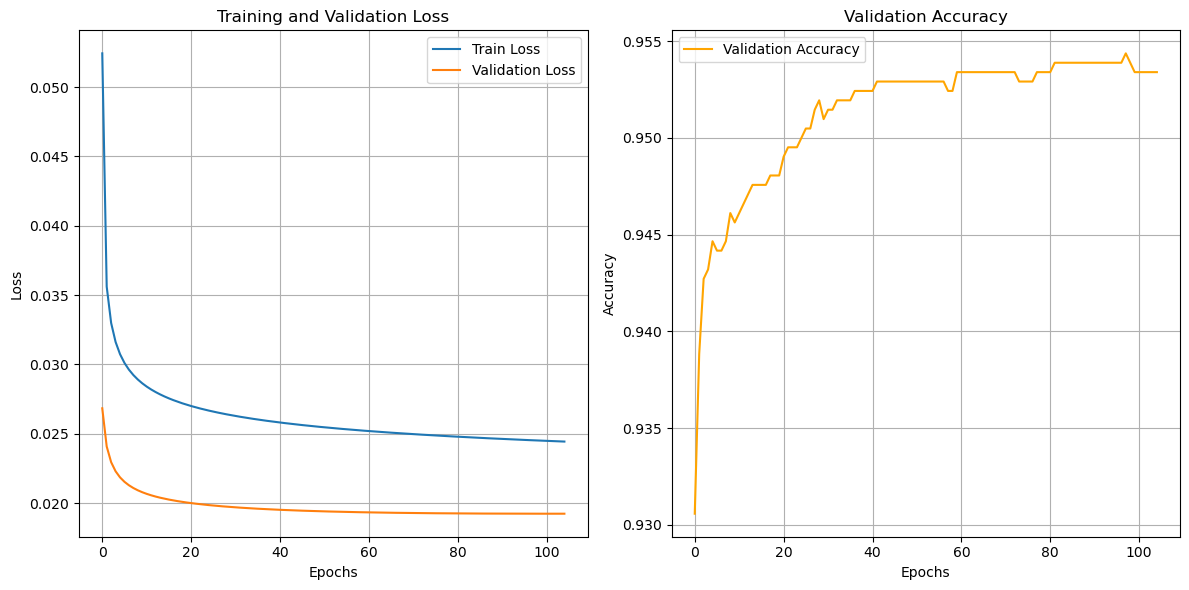

In [25]:
plt.figure(figsize=(12, 6))

# Plotting Training Loss and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Visualizing Learned Weights

Visualize the learned weights as images for each class

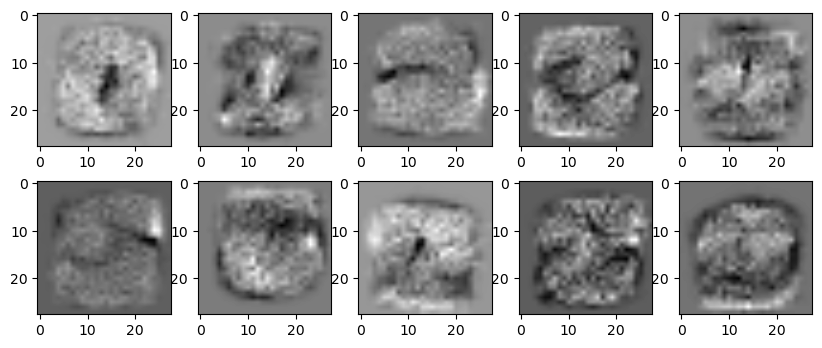

In [26]:
# The first set of weights is the bias, we can ignore those
layer_weights = softmaxRegressionModel.weights[1:]
layer_biases = softmaxRegressionModel.weights[0]

fig, axarr = plt.subplots(2, 5, figsize=(10,4))
for i in range(0,10):
    a = int(i/5)
    b = int(i%5)
    axarr[a,b].imshow(layer_weights[:,i].reshape(28,28), cmap = 'gray', interpolation = 'bilinear')


# Test Performance

Evaluate the model's accuracy on the test dataset

In [27]:
test_loss, test_accuracy = softmaxRegressionModel.test(test_set)
print("TEST ACCURACY:", test_accuracy)

TEST ACCURACY: 0.925
